# Getting started with `geovar`

This notebook highlights an instructive example of how to generate "GeoVar"-style plots using an example dataset of 5000 randomly chosen bi-allelic variants on Chromosome 22 from the new high-coverage sequencing of the [1000 Genomes Project from the New York Genome Center](http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/working/20190425_NYGC_GATK/)



## Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pkg_resources

from geovar.utils import vcf_to_freq_table
from geovar import GeoVar, GeoVarPlot

## Data

We have packaged both frequency tables as well as a gzipped vcf dataset within the `geovar` pacakge to illustrate how to move from a [VCF](https://samtools.github.io/hts-specs/VCFv4.2.pdf) file and a population specification file to a full `geovar`-style stacked barplot. 


In [2]:
data_path = pkg_resources.resource_filename("geovar", "data/")

# Filepath to the VCF File
vcf_file = "{}/new_1kg_nygc.chr22.biallelic_snps.filt.n5000.vcf.gz".format(data_path)

# Filepath to the population panel file
population_panel = "{}/integrated_call_samples_v3.20130502.1kg_superpops.panel".format(data_path)

While we may know what the specifications for the VCF format are, the format of the population panel (or cluster file) is defined as a two column file with the columns labeled `sample` and `pop` that are separated by whitespace. 

In [3]:
%%bash -s "$population_panel"

head -n5 $1 

sample pop
HG00096 EUR
HG00097 EUR
HG00099 EUR
HG00100 EUR


In [4]:
# Writing out VCF to a Frequency Table
af_df = vcf_to_freq_table(vcf_file, pop_panel=population_panel, outfile="{}/test.freq.csv".format(data_path), minor_allele=True)

# Print the beginning of the allele frequency table 
af_df.head()

,CHR,SNP,A1,A2,MAC,MAF,AFR,AMR,EAS,EUR,SAS
0,22,10662593,C,T,1,0.000201,0.000759,0.000000,0.000000,0.000000,0.000000
1,22,10664208,G,A,38,0.008137,0.028963,0.000000,0.000000,0.000000,0.000000
2,22,10666881,C,A,1,0.000218,0.000000,0.000000,0.000000,0.000000,0.001104
3,22,10670699,T,A,1633,0.354538,0.228395,0.379538,0.501029,0.259709,0.447137
4,22,10679257,A,T,35,0.007008,0.025797,0.001449,0.000000,0.000000,0.000000


## Generating a GeoVar Object 

Here we now are aiming to actually calculate the binned allele frequency categories (or geovar codes) for each variant across each population. The default binning scheme is to have a binning with (0,0.05], (0.05,0.5]. In theory one could have as many categories as one needs in order to 

In [5]:
# Creating the GeoVar Object 
geovar_test = GeoVar()

# Adding in the frequency file (all of it)
geovar_test.add_freq_mat(freq_mat_file="{}/test.freq.csv".format(data_path))

# Generate a geovar binning with the binning we used in our paper
geovar_test.geovar_binning()

# Printing details about the GeoVar object 
print(geovar_test)

GeoVar
number of variants: 5000
number of pops: 5
pops: AFR,AMR,EAS,EUR,SAS
allele freq bins: (0, 0),(0, 0.05),(0.05, 1.0)


## Visualization

Using the `GeoVar` object we created in the last section, we can generate a “GeoVar”-plot

In [6]:
geovar_plot = GeoVarPlot()

# Adding data directly from the geovar object itself
geovar_plot.add_data_geovar(geovar_test)

# Filter to remove very rare categories (only to speed up plotting)
geovar_plot.filter_data()

# Adding in a colormap
geovar_plot.add_cmap()

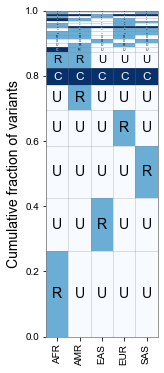

In [7]:
fig, ax = plt.subplots(1,1,figsize=(2,6))
geovar_plot.plot_geovar(ax);

If we want the percentages next to each value, we can run the following:

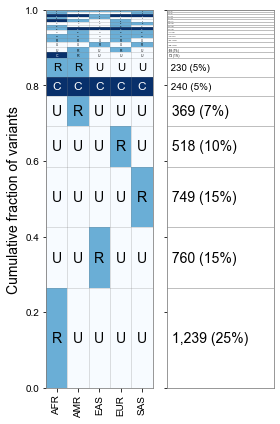

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(4,6), sharey=True)

geovar_plot.plot_geovar(ax[0]);

geovar_plot.plot_percentages(ax[1]);
plt.tight_layout()

## Changing the Binning  

Suppose that we want to distinguish between "low-frequency" ( 1% < MAF < 5%) and "rare" variants (MAF < 1%). We can do this by generating a new binning scheme for the `GeoVar` object and then rerunning our plotting code. 

In [9]:
# Setting new bins
geovar_test.generate_bins([0., 0.01, 0.05])

# Generating new geovar codes
geovar_test.geovar_binning()

In [10]:
geovar_plot2 = GeoVarPlot()

# Adding data directly from the geovar object itself
geovar_plot2.add_data_geovar(geovar_test)

# Filter to remove very rare categories (only to speed up plotting)
geovar_plot2.filter_data()

# Adding in a colormap and a new set of labels since we have an additional category
geovar_plot2.add_cmap(str_labels=['U','R','L','C'], lbl_colors=['black', 'black','white','white'])

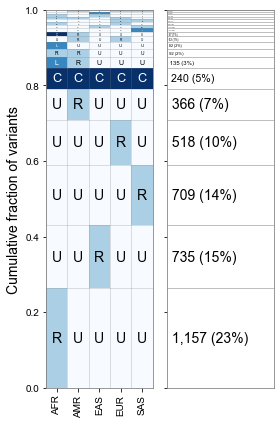

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(4,6), sharey=True)

geovar_plot2.plot_geovar(ax[0]);

geovar_plot2.plot_percentages(ax[1]);

plt.tight_layout()

As you can see the "L" category does not appear till the 7th category here, but it does allow for other ways to break down the frequency categories and further exploration. 

## Reading in from GeoVar Counts Files

For some datasets like the ~92 million variants in the [NYGC 1000 Genomes Project](http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/working/20190425_NYGC_GATK/), the full frequency table is too large to store in memory within a given jupyter notebook instance. 

In this case, we suggest processing the data in batches to create a geovar counts file, containing the numeric geovar code in the first column and the total count in the second column. We have included a file that we used in our analysis containing codes used in Figure 3B in Biddanda et al 2020.   

In [12]:
geovar_counts_file  = "{}/new_1kg_nyc_hg38_filt_total.biallelic_snps.superpops_amended2.ncat3x.filt_0.geodist_cnt.txt.gz".format(data_path)

In [13]:
%%bash -s "$geovar_counts_file"

# NOTE: the counts file is gzipped in this case!
# NOTE: you may have to change gzcat -> zcat on linux!
gzcat $1 | head -n5

00001 12330992
00002 6731
00010 14619729
00011 342372
00012 6324


In [14]:
geovar_plot3 = GeoVarPlot()

# Adding data directly from the geovar object itself
geovar_plot3.add_text_data(geovar_counts_file, filt_unobserved=False)

# Filter to remove very rare categories (only to speed up plotting)
geovar_plot3.filter_data()

# Adding in a colormap and a new set of labels since we have an additional category
geovar_plot3.add_cmap(str_labels=['U','R','C'], lbl_colors=['black', 'black','white'])
geovar_plot3.add_poplabels_manual(np.array(['AFR','EUR','SAS','EAS','AMR']))

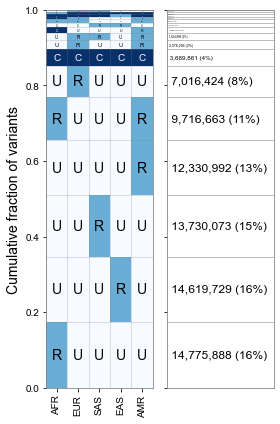

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(4,6), sharey=True)
geovar_plot3.plot_geovar(ax[0]);

# NOTE:  you can change the default fontsize parameter to alter
geovar_plot3.fontsize = 12
geovar_plot3.plot_percentages(ax[1]);
plt.tight_layout()